# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [6]:
# import libraries
from sqlalchemy import create_engine
import pandas as pd


In [9]:
# load data from database
engine = create_engine('sqlite:///DisasterResponse.db')
df = pd.read_sql('SELECT * FROM message', engine)
X = df.message
y = df.iloc[:, 4:]

### 2. Write a tokenization function to process your text data

In [10]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

def tokenize(text):
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens



### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [119]:
# First choose KNN calssifier , it is suitable for this situation

from sklearn.multioutput import MultiOutputClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
pipeline = Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer()),
                ('clf', MultiOutputClassifier(KNeighborsClassifier())),
                ])


### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [120]:
# split the train and test data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size =.3,random_state = 42)


In [121]:
# train the model and make predictions
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [122]:
# build a function to see if the prediction matches the y_test data

from sklearn.metrics import classification_report
'''
set a function to see the average precision, recall and f1 scores for each column
'''
def get_scores(y_pred,y_test):
    result = []
    for i in range(y_test.shape[1]): 
        test_value = y_test.iloc[:, i]
        pred_value = [a[i] for a in y_pred]
        result.append(list(classification_report(test_value, pred_value,output_dict = True)['0'].values())[:3])
    return pd.DataFrame(result,columns=['precision','recall','f1_score']).mean()

    
    

In [124]:
KNeighborsClassifier_score = get_scores(y_pred,y_test)
KNeighborsClassifier_score

precision    0.931183
recall       0.973001
f1_score     0.950552
dtype: float64

### 6. Improve your model
Use grid search to find better parameters. 

In [100]:
# use GridSearchCV to test several parameter combinations

pipeline = Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer()),
                ('clf', MultiOutputClassifier(KNeighborsClassifier())),
                ])
# first get the parameters of the pipeline
pipeline.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                   lowercase=True, max_df=1.0, max_features=None, min_df=1,
                   ngram_range=(1, 1), preprocessor=None, stop_words=None,
                   strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=<function tokenize at 0x1a1cd2d290>, vocabulary=None)),
  ('tfidf',
   TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)),
  ('clf',
   MultiOutputClassifier(estimator=KNeighborsClassifier(algorithm='auto',
                                                        leaf_size=30,
                                                        metric='minkowski',
                                                        metric_params=None,
                                                        n_jobs=None, n_neighbors=5,
           

In [194]:
# set 2*3*3 = 12 kinds of combinations

from sklearn.model_selection import GridSearchCV

parameters = { 
    'vect__max_df':[0.5,1.0],
    'clf__estimator__n_neighbors':[3,5,7],
    'clf__estimator__leaf_size':[20,30,40],    
    }

# in order to be quicker, set bags to 2 , and no limits to jobs
cv = GridSearchCV(pipeline, param_grid=parameters, cv = 2, n_jobs = -1)

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [131]:
# fit the train data
cv.fit(X_train, y_train)
# get the pred value
y_pred = cv.predict(X_test)



In [135]:
# check the finest parameter combinations
cv.best_params_

{'clf__estimator__leaf_size': 20,
 'clf__estimator__n_neighbors': 5,
 'vect__max_df': 0.5}

In [138]:
# get the three scores of the best combination
get_scores(y_pred,y_test)

precision    0.929722
recall       0.978194
f1_score     0.952168
dtype: float64

We can see, after setting 3 parameters, the average f1 score increased about 0.0017 (from 0.9505 to 0.9522), that's not good enough.

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [169]:
#first, try to add a text length feature and a starting verb feature
import nltk
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

class TextLengthExtractor(BaseEstimator, TransformerMixin):

    def textlength(self, text):        
        return len(tokenize(text))

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        X_tagged = pd.Series(X).apply(self.textlength)
        return pd.DataFrame(X_tagged)


class StartingVerbExtractor(BaseEstimator, TransformerMixin):

    def starting_verb(self, text):
        sentence_list = nltk.sent_tokenize(text)
        for sentence in sentence_list:
            pos_tags = nltk.pos_tag(tokenize(sentence))
            first_word, first_tag = pos_tags[0]
            if first_tag in ['VB', 'VBP'] or first_word == 'RT':
                return True
        return False

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        X_tagged = pd.Series(X).apply(self.starting_verb)
        return pd.DataFrame(X_tagged)



In [197]:
# add the above two features to the pipeline
pipeline_union = Pipeline([
    ('features', FeatureUnion([

        ('nlp_pipeline', Pipeline([
            ('vect', CountVectorizer(tokenizer=tokenize,max_df =0.5)),
            ('tfidf', TfidfTransformer())
             ])),

        ('txt_len', TextLengthExtractor()),
        ('start_verb', StartingVerbExtractor())
    ])),

    ('clf', MultiOutputClassifier(KNeighborsClassifier(leaf_size =20)))
])



In [198]:
# fit the data, and make predictions
pipeline_union.fit(X_train, y_train)
y_pred_union = pipeline_union.predict(X_test)

In [200]:
# get the score
get_scores(y_pred_union,y_test)

precision    0.934191
recall       0.957524
f1_score     0.944294
dtype: float64

After adding the new feature, the f1 score do not getting better.
Next, I will try another classifier

In [179]:
# try randomforestclassifier
from sklearn.ensemble import RandomForestClassifier

pipeline_rf = Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer()),
                ('clf', MultiOutputClassifier(RandomForestClassifier())),
                ])
# use default settings and run the fitting and prediction  
pipeline_rf.fit(X_train, y_train)
y_pred_rf = pipeline_rf.predict(X_test)

In [181]:
# get the scores
get_scores(y_pred_rf,y_test)

precision    0.944321
recall       0.973485
f1_score     0.955139
dtype: float64

The average f1_scores increased for about 0.003, to 0.9551.
I will try NBclassifier

In [213]:
# try naive bayes classifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import FunctionTransformer

pipeline_nb = Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer()),
                ('todense',FunctionTransformer(lambda x: x.todense(), accept_sparse=True)), 
                ('clf', MultiOutputClassifier(GaussianNB())),
                ])

pipeline_nb.fit(X_train, y_train)
y_pred_nb = pipeline_nb.predict(X_test)



In [214]:
get_scores(y_pred_nb,y_test)

precision    0.929827
recall       0.778979
f1_score     0.842159
dtype: float64

It seems GaussianNB is not as good as above two classifiers.
RandomForestClassifier has the highest f1 score.

At last, I will use GridSearchCV to set several parameters to improve RandomForestClassifier

In [237]:
# set the pipeline
pipeline_randomfo = Pipeline([
    ('features', FeatureUnion([

        ('nlp_pipeline', Pipeline([
            ('vect', CountVectorizer(tokenizer=tokenize, max_df = 0.5)),
            ('tfidf', TfidfTransformer())
             ])),

        ('txt_len', TextLengthExtractor()),
        ('start_verb', StartingVerbExtractor())
    ])),

    ('clf', MultiOutputClassifier(RandomForestClassifier(min_samples_leaf =1,n_estimators = 1000)))
])

In [238]:
# get parameters
pipeline_randomfo.get_params()

{'memory': None,
 'steps': [('features', FeatureUnion(n_jobs=None,
                transformer_list=[('nlp_pipeline',
                                   Pipeline(memory=None,
                                            steps=[('vect',
                                                    CountVectorizer(analyzer='word',
                                                                    binary=False,
                                                                    decode_error='strict',
                                                                    dtype=<class 'numpy.int64'>,
                                                                    encoding='utf-8',
                                                                    input='content',
                                                                    lowercase=True,
                                                                    max_df=0.5,
                                                                    max_fea

In [239]:
# set several parameter combinations.
# Because RandomforestClassier is very time consumming, I can't try too many parameters
parameters = {
        'features__nlp_pipeline__vect__max_features': (5000, 10000),
        'features__nlp_pipeline__tfidf__use_idf': (True, False),
        'clf__estimator__min_samples_split': [2, 4],
        }


In [240]:
# set the GridSearchCV, in order to run quicker, set cv = 2
cv_randomfo = GridSearchCV(pipeline_randomfo, param_grid=parameters, cv = 2, n_jobs = -1)

In [241]:
# fit the train data
cv_randomfo.fit(X_train, y_train)
# get the pred value
y_pred_randomfo = cv_randomfo.predict(X_test)


In [243]:
cv_randomfo.best_params_

{'clf__estimator__min_samples_split': 4,
 'features__nlp_pipeline__tfidf__use_idf': True,
 'features__nlp_pipeline__vect__max_features': 5000}

In [244]:
get_scores(y_pred_randomfo,y_test)

/Users/xuhao3/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision    0.949215
recall       0.971371
f1_score     0.956984
dtype: float64

In [245]:
# set the parameters and rerun the ML process using randomforest
pipeline_randomforest = Pipeline([
    ('features', FeatureUnion([

        ('nlp_pipeline', Pipeline([
            ('vect', CountVectorizer(tokenizer=tokenize,
                                     max_df = 0.5,
                                     max_features = 5000)),
            ('tfidf', TfidfTransformer(use_idf = True))
             ])),

        ('txt_len', TextLengthExtractor()),
        ('start_verb', StartingVerbExtractor())
    ])),

    ('clf', MultiOutputClassifier(RandomForestClassifier(min_samples_leaf =1,
                                                         n_estimators = 1000,
                                                         min_samples_split = 4)))
    ])

In [246]:
pipeline_randomforest.fit(X_train, y_train)
y_pred_randomforest = pipeline_randomforest.predict(X_test)


In [247]:
get_scores(y_pred_randomforest,y_test)

/Users/xuhao3/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision    0.949207
recall       0.971228
f1_score     0.956889
dtype: float64

After setting several parameters, the f1 score increased for another 0.0015.
I will stop improving my model here for:
1. The f1 score is high enough, it's difficult to have big improvement.
2. Run every single randomforestcalssifier for the dataset costs about an hour, if
In order to save the model to a pickle file, I will rerun the ML process again.

In [ ]:
category_names = list(y.columns)

def evaluate_model(pipeline_randomforest, X_test, y_test, category_names):
    y_pred = model.predict(X_test)
    
    result = []
    for i in range(y_test.shape[1]): 
        test_value = y_test.iloc[:, i]
        pred_value = [a[i] for a in y_pred]
        result.append(list(classification_report(test_value, pred_value,output_dict = True)['0'].values())[:3])
    
    df = pd.DataFrame(result,columns=['precision','recall','f1_score'])
    df['indicator'] = pd.Series(category_names)
    
    print(df)
    print('The average precision, recall and f1_score are {},{},{}'.
          format(df.precision.mean(),df.recall.mean(),df.f1_score.mean()))



In [248]:
category_names = list(y.columns)

In [249]:
result = []
for i in range(y_test.shape[1]): 
    test_value = y_test.iloc[:, i]
    pred_value = [a[i] for a in y_pred]
    result.append(list(classification_report(test_value, pred_value,output_dict = True)['0'].values())[:3])



In [250]:
df3 = pd.DataFrame(result,columns=['precision','recall','f1_score'])

In [253]:
df3['indicator'] = category_names

In [254]:
df3

,precision,recall,f1_score,indicator
0,0.533510,0.429258,0.475740,related
1,0.876931,0.981632,0.926333,request
2,0.995422,0.999872,0.997642,offer
3,0.655810,0.931769,0.769805,aid_related
4,0.922367,0.996264,0.957893,medical_help
5,0.949527,0.997851,0.973090,medical_products
6,0.976330,0.999870,0.987960,search_and_rescue
7,0.981686,0.999741,0.990631,security
8,0.969824,0.999606,0.984490,military
9,1.000000,1.000000,1.000000,child_alone


### 9. Export your model as a pickle file

In [255]:
import pickle
pickle.dump(pipeline_randomforest, open('model_randomforest.pkl', 'wb'))

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.

In [3]:
%%file train_classifier.py

import sys
from sqlalchemy import create_engine
import pandas as pd
import pickle

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin

def load_data(database_filepath):
    '''
    Load dataframe from a database
    '''
    engine = create_engine('sqlite:///'+database_filepath)
    df = pd.read_sql('SELECT * FROM message', engine)
    X = df.message
    y = df.iloc[:, 4:]
    category_names = list(y.columns)
    
    return X, y, category_names

def tokenize(text):
    '''
    Tokenize and lemmatize the text
    '''
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens

class TextLengthExtractor(BaseEstimator, TransformerMixin):
    '''
    A class to get the length of each tokenized text, and apply the function to all cells
    '''
    def textlength(self, text):        
        return len(tokenize(text))

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        X_tagged = pd.Series(X).apply(self.textlength)
        return pd.DataFrame(X_tagged)


class StartingVerbExtractor(BaseEstimator, TransformerMixin):
    '''
    A class to see if the first letter is a verb, and apply the function to all cells
    '''
    def starting_verb(self, text):
        sentence_list = nltk.sent_tokenize(text)
        for sentence in sentence_list:
            pos_tags = nltk.pos_tag(tokenize(sentence))
            first_word, first_tag = pos_tags[0]
            if first_tag in ['VB', 'VBP'] or first_word == 'RT':
                return True
        return False

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        X_tagged = pd.Series(X).apply(self.starting_verb)
        return pd.DataFrame(X_tagged)

def build_model():
    '''
    Build the model
    '''
    pipeline_randomforest = Pipeline([
    ('features', FeatureUnion([

        ('nlp_pipeline', Pipeline([
            ('vect', CountVectorizer(tokenizer=tokenize,
                                     max_df = 0.5,
                                     max_features = 5000)),
            ('tfidf', TfidfTransformer(use_idf = True))
             ])),

        ('txt_len', TextLengthExtractor()),
        ('start_verb', StartingVerbExtractor())
    ])),

    ('clf', MultiOutputClassifier(RandomForestClassifier(min_samples_leaf =1,
                                                         n_estimators = 1000,
                                                         min_samples_split = 4)))
    ])
    
    return pipeline_randomforest


def evaluate_model(model, X_test, y_test, category_names):
    '''
    use the model to make prediction, and print out every column's precision, recall and fi scores
    '''
    y_pred = model.predict(X_test)
    
    result = []
    for i in range(y_test.shape[1]): 
        test_value = y_test.iloc[:, i]
        pred_value = [a[i] for a in y_pred]
        result.append(list(classification_report(test_value, pred_value,output_dict = True)['0'].values())[:3])
    
    df = pd.DataFrame(result,columns=['precision','recall','f1_score'])
    df['indicator'] = pd.Series(category_names)
    
    print(df)
    print('The average precision, recall and f1_score are {},{},{}'.
          format(df.precision.mean(),df.recall.mean(),df.f1_score.mean()))

def save_model(model, model_filepath):
    '''
    Save the model to a .pkl file
    '''
    pickle.dump(model, open('model_randomforest.pkl', 'wb'))


def main():
    
    
    if len(sys.argv) == 3:
        database_filepath, model_filepath = sys.argv[1:]
        print('Loading data...\n    DATABASE: {}'.format(database_filepath))
        X, y, category_names = load_data(database_filepath)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        
        print('Building model...')
        model = build_model()
        
        print('Training model...')
        model.fit(X_train, y_train)
        
        print('Evaluating model...')
        evaluate_model(model, X_test, y_test, category_names)

        print('Saving model...\n    MODEL: {}'.format(model_filepath))
        save_model(model, model_filepath)

        print('Trained model saved!')

    else:
        print('Please provide the filepath of the disaster messages database '\
              'as the first argument and the filepath of the pickle file to '\
              'save the model to as the second argument. \n\nExample: python '\
              'train_classifier.py ../data/DisasterResponse.db classifier.pkl')


if __name__ == '__main__':
    main()
    
    


Writing train_classifier.py


In [4]:
!python train_classifier.py DisasterResponse.db model_randomforest.pkl

Loading data...
    DATABASE: DisasterResponse.db
Building model...
Training model...
Evaluating model...
/Users/xuhao3/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
    precision    recall  f1_score               indicator
0    0.718941  0.286526  0.409750                 related
1    0.903472  0.980699  0.940502                 request
2    0.995423  1.000000  0.997706                   offer
3    0.784237  0.850227  0.815900             aid_related
4    0.929373  0.995028  0.961081            medical_help
5    0.956890  0.998594  0.977297        medical_products
6    0.974506  0.998037  0.986131       search_and_rescue
7    0.981298  0.999417  0.990274                security
8    0.972616  0.999213  0.985735           

In [28]:
df2.message

0        Weather update - a cold front from Cuba that c...
1                  Is the Hurricane over or is it not over
2                          Looking for someone but no name
3        UN reports Leogane 80-90 destroyed. Only Hospi...
4        says: west side of Haiti, rest of the country ...
                               ...                        
26211    The training demonstrated how to enhance micro...
26212    A suitable candidate has been selected and OCH...
26213    Proshika, operating in Cox's Bazar municipalit...
26214    Some 2,000 women protesting against the conduc...
26215    A radical shift in thinking came about as a re...
Name: message, Length: 26216, dtype: object

In [30]:
df2.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
engine = create_engine('sqlite:///DisasterResponse.db')
df2 = pd.read_sql('SELECT * FROM message', engine)

In [17]:
indicators = df2.iloc[:,4:].sum().sort_values(ascending = False)

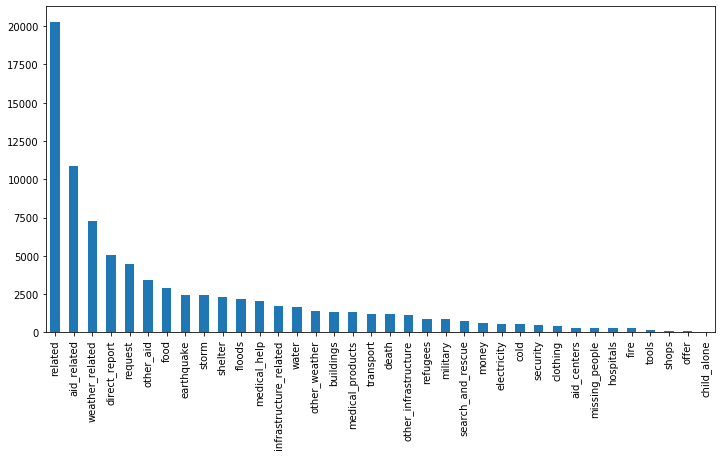

In [21]:
import matplotlib.pyplot as plt

indicators.plot(kind = 'bar',figsize = (12,6));

In [22]:
df2.groupby('genre').count()['message']

genre
direct    10766
news      13054
social     2396
Name: message, dtype: int64

In [24]:
df2.groupby('genre').count()['message'].index

Index(['direct', 'news', 'social'], dtype='object', name='genre')

In [23]:
df2.iloc[:,4:].sum().sort_values(ascending = False)

related                   20282
aid_related               10860
weather_related            7297
direct_report              5075
request                    4474
other_aid                  3446
food                       2923
earthquake                 2455
storm                      2443
shelter                    2314
floods                     2155
medical_help               2084
infrastructure_related     1705
water                      1672
other_weather              1376
buildings                  1333
medical_products           1313
transport                  1201
death                      1194
other_infrastructure       1151
refugees                    875
military                    860
search_and_rescue           724
money                       604
electricity                 532
cold                        530
security                    471
clothing                    405
aid_centers                 309
missing_people              298
hospitals                   283
fire    

In [25]:
df2.iloc[:,4:].sum().sort_values(ascending = False).index

Index(['related', 'aid_related', 'weather_related', 'direct_report', 'request',
       'other_aid', 'food', 'earthquake', 'storm', 'shelter', 'floods',
       'medical_help', 'infrastructure_related', 'water', 'other_weather',
       'buildings', 'medical_products', 'transport', 'death',
       'other_infrastructure', 'refugees', 'military', 'search_and_rescue',
       'money', 'electricity', 'cold', 'security', 'clothing', 'aid_centers',
       'missing_people', 'hospitals', 'fire', 'tools', 'shops', 'offer',
       'child_alone'],
      dtype='object')

In [31]:
df2.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df2.groupby('genre')